# Centrifugal compressor - Performance Map

Ejemplo de como hacer uso de regresion multivariable para estimar el mapa de desempeño de un compresor centrífugo multietapas.

## Curva de desempeño segun el OEM

El mapa es el de presión de descarga en unidades de absolutas kg/cm<sup>2</sup> en función del caudal de gas en unidades de Am<sup>3</sup>/h

Por cada mapa se encuentran 4 curvas:
- 80% de velocidad de giro
- 90% de velocidad de giro
- 100% de velocidad de giro
- 107% de velocidad de giro

## Data de procesos

Los datos que fueron suministrados fueron guardados en archivos de textos con la siguiente nomenclatura:

- K301: Nombre del compresor
- 1st: Indica la etapa del compresor
- DP: Indica la propiedad que se mide, DP es la presión de descarga
- XXX: Indica el porcentaje de la velocidad de giro

In [1]:
# Valores fisicos de referencia

P1_OEM = 16.53          # Presion de succion, kg/cm2
T1_OEM = 39 + 273.15    # Temperatura de succion, K
P2_OEM = 37.35          # Presion de descarga, kg/cm2
T2_OEM = 135.2 + 273.15 # Temperatura de descarga, K
Q_OEM = 20684           # Flujo volumetrico, Am^3/h
M_OEM = 129722          # Flujo masico, kg/h
MW_OEM = 10.15          # Peso molecular
PH_OEM = 24702          # Cabezal politropico, kgm/kg
RPM_OEM = 10096         # Velocidad de giro, rpm

## Visualizacion de los datos experimentales

Estos mapas están referenciados a una condición de prueba de banco, cuyos valores son los siguientes:

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit, least_squares

/Users/aliglara/miniconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
folderMapas = "../files/data/"

# Curvas para el mapa de presion de descarga
df1stDP080 = np.loadtxt(folderMapas + 'K301-1st-DP080.txt', delimiter='\t', skiprows=1)
df1stDP090 = np.loadtxt(folderMapas + 'K301-1st-DP090.txt', delimiter='\t', skiprows=1)
df1stDP100 = np.loadtxt(folderMapas + 'K301-1st-DP100.txt', delimiter='\t', skiprows=1)
df1stDP107 = np.loadtxt(folderMapas + 'K301-1st-DP107.txt', delimiter='\t', skiprows=1)

# Reorganizacion de los datos
df1stDP = np.concatenate([df1stDP080, df1stDP090, df1stDP100, df1stDP107], axis=0)

caudal = df1stDP[:, 0]
P2 = df1stDP[:, 1]
rpm = np.concatenate([np.ones(np.size(df1stDP080,0)) * 0.8, 
                    np.ones(np.size(df1stDP090,0)) * 0.9,
                    np.ones(np.size(df1stDP100,0)), 
                    np.ones(np.size(df1stDP107,0)) * 1.07])  * 100

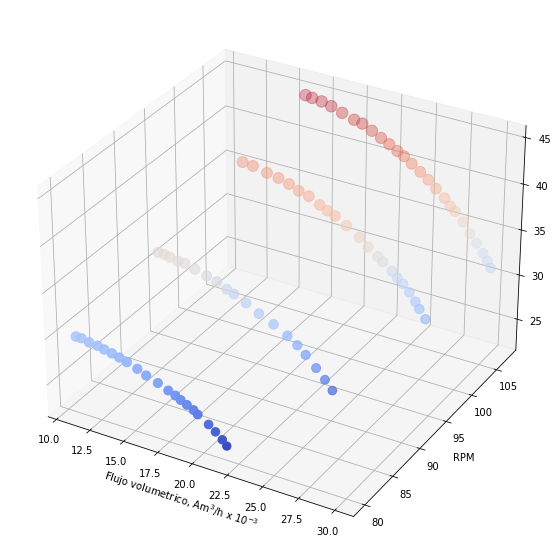

In [10]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.scatter(caudal, rpm, P2, c=P2, s=P2*3, cmap='coolwarm')
ax.set_ylabel('RPM ')
ax.set_xlabel('Flujo volumetrico, Am$^3$/h x 10$^{-3}$')
plt.savefig('performance_map.png', dpi=72, bbox_inches='tight')
plt.show()


## Regresion de los mapas OEM

Ahora los datos experimentales se ajustan a un polinomio multivariable de segundo orden, con la siguiente forma

\begin{equation*}
RPM = a + b\cdot X + c\cdot Q + d\:X\cdot Q + e\cdot Q^2 + f \cdot X^2 
\end{equation*}

donde *a, b, c, d, e* y *f* son los coeficientes de ajuste, *Q* es el flujo volumetrico del gas, *X* representa la variable de proceso relativa al compresor y _RPM_ representa la velocidad de giro del compresor.

Las variables independientes son el flujo de gas y la variable de salida del compresor: presion de descarga, cabezal politropico o potencia al freno. Mientras la variable dependiente es la velocidad de giro del compresor.


In [5]:
def mapFit(x, a, b, c, d, e, f):
    '''
    regresion multivariable de los datos experimentales x
    output: a, b, c, d, e, f : coeficientes de regresion
    '''
    x1 = x[:,0]
    x2 = x[:,1]
    return a * x2 + b * x1 + c * x1 * x2 + d + e * x1**2 + f * x2**2

def fpredict(x1, y, coef, seed):
    '''
    funcion a minimizar empleando el metodo de minimos cuadrados.
    
    '''
    a, b, c, d, e, f = coef
    ftemp = lambda x2: y - (a * x2 + b * x1 + c * x1 * x2 + d + e * x1**2 + f * x2**2)
    return least_squares(ftemp, seed)

In [6]:
params = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
coefRpmDP1st,_ = curve_fit(mapFit, df1stDP, rpm, p0=params)

## Comparacion de resultados

Se crea vectores de flujo de gas que se encuentren entre los valores caudal de surge y stonewall para cada curva de velocidad de giro del compresor.

In [7]:
# Valores para la variable independiente, caudal
n_puntos = 100

Q080_val = np.linspace(min(df1stDP080[:,0]), max(df1stDP080[:,0]), n_puntos)
Q090_val = np.linspace(min(df1stDP090[:,0]), max(df1stDP090[:,0]), n_puntos)
Q100_val = np.linspace(min(df1stDP100[:,0]), max(df1stDP100[:,0]), n_puntos)
Q107_val = np.linspace(min(df1stDP107[:,0]), max(df1stDP107[:,0]), n_puntos)


In [8]:
# Prediciones de la presion de descarga (P2) segun el modelo de ajuste

dp080 = [fpredict(X, 80, coefRpmDP1st, 27).x[0] for X in Q080_val]
dp090 = [fpredict(X, 90, coefRpmDP1st, 30).x[0] for X in Q090_val]
dp100 = [fpredict(X, 100, coefRpmDP1st, 35).x[0] for X in Q100_val]
dp107 = [fpredict(X, 107, coefRpmDP1st, 40).x[0] for X in Q107_val]

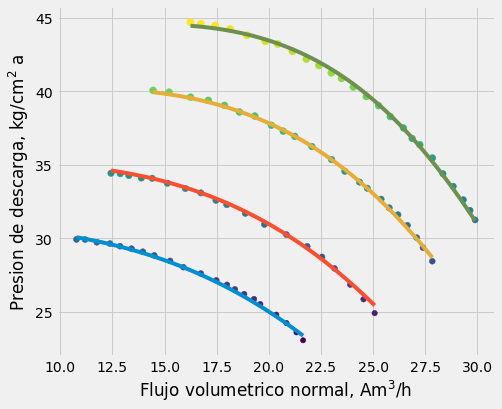

In [11]:
# Comparacion grafica
plt.style.use('fivethirtyeight')
# Valores experimentales
Q_oem = df1stDP[:, 0]
DP_oem = df1stDP[:, 1] #* 0.980665  # conversion from kg/cm^2 to bar

fig, ax = plt.subplots(figsize=(7, 6))

ax.scatter(Q_oem, DP_oem, c=DP_oem, s=DP_oem*1.2)
ax.plot(Q080_val, dp080)
ax.plot(Q090_val, dp090)
ax.plot(Q100_val, dp100)
ax.plot(Q107_val, dp107)
ax.set_xlabel('Flujo volumetrico normal, Am$^3$/h')
ax.set_ylabel('Presion de descarga, kg/cm$^2$ a')

fig.savefig('resultado-regresion-map.png', dpi=72)
plt.show()

El metodo de regresion es adecuado para este caso.